### 1. Data Understanding and Selection

#### Data Collection Overview
In this project, I wanted to explore my music genres using my personal Spotify 2023 playlists data. I have been in the top 0.01 listeners for 2022 and 2023 on Spotify and always wondered how my Spotify data looked like. The app actually tracks much data than I ever anticipated. After waiting for 5 days, they gave me a bunch of JSON files and the playlists was interesting one. I wanted to see which genres or what kind of audio do I add in my playlists. The downloaded Playlist JSON spotify data has artist names, track names, album names, and crucially, track Id information unique for each track. Nothing much insightful as I expected. So, I used Python scripts in Visual Studio Code (VSCode), which allowed me to automate the data conversion and initial data exploration. 

#### Selection Rationale
My decision to focus on Spotify data was driven by my keen interest in music and its characteristics. Breaking down the musics in some of my Playlists sounds interesting and since I am mostly familiar witht he music production, I was interested in grabbing the audio features for my nearly 1700 favorite songs and explore patterns. This is nice since music genres offer a rich domain for the classification tasks due to their inherent diversity and the subjective nature of genre classification that makes it challenging. So, I used Spotify's API to fetch the audio features and build enriched dataset. By building this dataset, I want to uncover patterns and insights into my musical preferences and broader genre classification trends. This dataset is not only personal but also sufficiently complex to demonstrate the practical application of machine learning techniques in a real-world context. Below are my detailed process and Python scripts for the data preprocessing.

### 2. Data Preprocessing

#### Initial Data Processing
The initial step involved converting the raw JSON files obtained from the Spotify API into a structured CSV format. This transformation was vital for simplifying subsequent data manipulation and analysis tasks. The conversion process entailed parsing the JSON files to extract relevant track metadata and compiling this information into a tabular format--CSV files.

#### Data Enrichment
To enhance the dataset's utility for genre classification, I used the Spotify API to enrich the dataset with genre labels and audio features for each track. The enriched dataset now contains a comprehensive set of audio features, including both the metadata initially extracted and the newly appended audio features and genre labels.

#### Preprocessing Techniques
With the enriched dataset in place, the focus shifted to preprocessing the data to prepare it for machine learning modeling. Key steps in this phase included:

- **Data Cleaning**: I carefully cleaned the dataset to remove any inconsistencies or missing values. This step ensured that the dataset was free from anomalies that could potentially skew the analysis.
  
- **Feature Engineering**: I did feature engineering to extract and select the most informative attributes for the genre classification task. It involved analyzing the dataset to identify features that significantly impact genre classification.

- **Data Standardization**: Given the diverse range of numerical values across different features, I applied data standardization techniques to ensure that all features contributed equally to the model's performance. This step was critical for models sensitive to the scale of input features.

- **Data Splitting**: The dataset was split into training and testing subsets, allowing for the evaluation of model performance on unseen data. This practice is essential for assessing the generalizability of the machine learning models developed.

These preprocessing steps are vital in shaping the raw, enriched dataset into a form amenable to machine learning model analysis.

In [ ]:
# For data collection from Spotify API
import pandas as pd
import json

def export_playlist_to_csv(playlist_name, playlist_items, file_name):
    """
    Export the tracks of a playlist to a CSV file.
    
    Args:
        playlist_name (str): The name of the playlist.
        playlist_items (list): List of items in the playlist.
        file_name (str): The name of the CSV file to be created.
    Returns:
        None
    """
    # Initialize an empty list to store track data
    tracks_data = []
    
    # Iterate over each item in the playlist
    for item in playlist_items:
        track = item['track']
        if track:  # Ensure there is track data
            # Extract relevant track information and append to tracks_data list
            tracks_data.append({
                'trackId': track['trackUri'].split(':')[-1],
                'trackName': track['trackName'],
                'artistName': track['artistName'],
                'albumName': track['albumName']
            })
    
    # Create a DataFrame from the tracks data
    df_tracks = pd.DataFrame(tracks_data)
    
    # Write the DataFrame to a CSV file
    df_tracks.to_csv(file_name, index=False)

# Load the JSON data
with open('Playlist1.json', 'r') as file:
    data = json.load(file)

# Example: Export 4 of my playlists to CSV - 'Reserve' and 'Summer Workout' etc.
for playlist in data['playlists']:
    # Check if the playlist name is in the list of selected playlists
    if playlist['name'] in ['Reserve', 'Summer Workout', 'Progressive house', 'Unconditional']:
        # Generate the file name for the CSV based on the playlist name
        file_name = f"{playlist['name'].replace(' ', '_')}.csv"
        # Export the playlist to a CSV file using the export_playlist_to_csv function
        export_playlist_to_csv(playlist['name'], playlist['items'], file_name)

#### Using Spotify API to Enrich the Dataset
This is calling the Spotify `audio-features` endpoint to grab each song's details using the track ID from the previously converted JSON object. Then it updates the current csv file to add these features.

In [ ]:
import requests
import pandas as pd

def get_spotify_access_token(client_id, client_secret):
    """
    Retrieve an access token from Spotify API using client credentials flow.
    
    Args:
        client_id (str): The client ID for accessing Spotify API.
        client_secret (str): The client secret for accessing Spotify API.
    
    Returns:
        str: Access token if successfully obtained, None otherwise.
    """
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_response = requests.post(auth_url, {
        'grant_type': 'client_credentials',
        'client_id': client_id,
        'client_secret': client_secret,
    })
    if auth_response.status_code == 200:  # Success
        return auth_response.json().get('access_token')
    else:
        print("Failed to obtain access token")
        return None

def enrich_track_data(df, access_token):
    """
    Enrich the track data DataFrame with Spotify audio features and artist genres.
    
    Args:
        df (DataFrame): DataFrame containing track data.
        access_token (str): Access token for accessing Spotify API.
    
    Returns:
        DataFrame: DataFrame enriched with Spotify data.
    """
    base_url = 'https://api.spotify.com/v1/'
    headers = {'Authorization': f'Bearer {access_token}'}

    for index, row in df.iterrows():
        track_id = row['trackId']
        audio_features_url = f'{base_url}audio-features/{track_id}'
        track_details_url = f'{base_url}tracks/{track_id}'

        # Fetch audio features
        try:
            audio_features_response = requests.get(
                audio_features_url, headers=headers)
            if audio_features_response.status_code == 200:  # Success
                audio_features_data = audio_features_response.json()
                for feature in ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                                'acousticness', 'instrumentalness', 'liveness', 'valence',
                                'tempo', 'duration_ms', 'time_signature']:
                    df.at[index, feature] = audio_features_data.get(feature)
            else:
                print(
                    f"Audio features for track ID {track_id} could not be fetched.")

            # Fetch track details to get artist ID
            track_details_response = requests.get(
                track_details_url, headers=headers)
            if track_details_response.status_code == 200:  # Success
                track_details_data = track_details_response.json()
                artist_id = track_details_data['artists'][0]['id'] if track_details_data['artists'] else None

                # Fetch genres from the artist's data
                if artist_id:
                    artist_url = f'{base_url}artists/{artist_id}'
                    artist_response = requests.get(artist_url, headers=headers)
                    if artist_response.status_code == 200:
                        artist_data = artist_response.json()
                        df.at[index, 'genres'] = ', '.join(
                            artist_data.get('genres', []))
                    else:
                        print(
                            f"Genres for artist ID {artist_id} could not be fetched.")
        except requests.exceptions.RequestException as e:
            print(f"Request failed for track ID {track_id}: {e}")
        except ValueError as e:
            print(
                f"Failed to decode JSON response for track ID {track_id}: {e}")

    return df

# Your Spotify API credentials and access token retrieval
client_id = '42c5a306556842c480894e512ff6726b'
client_secret = 'f09faadcd6304085aa481de32fc808ed'
access_token = get_spotify_access_token(client_id, client_secret)

# Load the cleaned data and enrich it with Spotify data
df_cleaned = pd.read_csv('enriched_combined_csv.csv')

# Assuming 'df_cleaned' is already loaded from 'cleaned_combined_csv.csv'
# Enrich the DataFrame with additional Spotify data
if access_token:
    df_enriched = enrich_track_data(df_cleaned, access_token)
    df_enriched.to_csv('final.csv', index=False)
else:
    print("Could not enrich data without an access token.")

#### The Clean Up and Data preparation part

Here I am mapping the small and detailed genres to broad categories which are `EDM`, `Pop`, and `Indie/Alternative`. The reason is that the small genres are too specific for the classification purpose as well. And this mapping also helps for detailed noisy data removal as I am removing the unmapped specific genres in the dataset. I also manually update the genre labeling to ensure the mapping doesn't mislable tracks into wrong broad genre categories. 

In [ ]:
# Purpose: Clean the final.csv dataset and map detailed genres to broad categories
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('final.csv')  # Update the path

# Define a mapping of detailed genres to broad categories
genre_mapping = {
    # EDM
    'edm': 'EDM', 'electro house': 'EDM', 'progressive electro house': 'EDM',
    'dutch house': 'EDM', 'big room': 'EDM', 'melodic dubstep': 'EDM',
    'brostep': 'EDM', 'dutch edm': 'EDM', 'future bass': 'EDM',
    'progressive trance': 'EDM', 'house': 'EDM', 'indietronica': 'EDM',
    'complextro': 'EDM', 'slap house': 'EDM', 'canadian electronic': 'EDM',
    'vapor twitch': 'EDM', 'electronic trap': 'EDM', 'stutter house': 'EDM',
    'bass trap': 'EDM', 'australian dance': 'EDM', 'trance': 'EDM',
    'future house': 'EDM', 'german techno': 'EDM', 'belgian edm': 'EDM',
    'swedish tropical house': 'EDM', 'melbourne bounce': 'EDM', 'trancecore': 'EDM',
    'belgian dance': 'EDM', 'gaming edm': 'EDM', 'progressive house': 'EDM', 'tropical house': 'EDM',
    'metropopolis': 'EDM', 'uk dance': 'EDM', 'sky room': 'EDM', 'hopebeat': 'EDM', 'dubstep': 'EDM',
    'swedish electropop': 'EDM', 'electropowerpop': 'EDM',

    # Pop
    'pop': 'Pop', 'pop edm': 'Pop', 'pop dance': 'Pop', 'dance pop': 'Pop', 'canadian pop': 'Pop', 'uk pop': 'Pop',
    'nyc pop': 'Pop', 'pop rap': 'Pop', 'shimmer pop': 'Pop',
    'swedish pop': 'Pop', 'la pop': 'Pop', 'singer-songwriter pop': 'Pop',
    'norwegian pop': 'Pop', 'australian pop': 'Pop', 'danish pop': 'Pop',
    'russian edm': 'Pop', 'australian electropop': 'Pop', 'pop soul': 'Pop',
    'latin pop': 'Pop', 'indian edm': 'Pop', 'korean r&b': 'Pop',
    'uk alternative pop': 'Pop', 'pop nacional': 'Pop', 'italian pop': 'Pop',
    'nz pop': 'Pop', 'latin viral pop': 'Pop', 'pop rock': 'Pop',
    'pop emo': 'Pop', 'pop punk': 'Pop', 'mellow gold': 'Pop',
    'candy pop': 'Pop', 'irish pop': 'Pop', 'piano rock': 'Pop',

    # Indie/Alternative
    'indie poptimism': 'Indie/Alternative', 'alt z': 'Indie/Alternative',
    'indie electropop': 'Indie/Alternative', 'modern indie pop': 'Indie/Alternative',
    'indie pop': 'Indie/Alternative', 'indie pop rap': 'Indie/Alternative',
    'indie anthem-folk': 'Indie/Alternative', 'modern alternative rock': 'Indie/Alternative',
    'indie r&b': 'Indie/Alternative', 'swedish indie': 'Indie/Alternative',
    'neo-synthpop': 'Indie/Alternative', 'post-teen pop': 'Indie/Alternative',
    'neon pop punk': 'Indie/Alternative', 'indie rock': 'Indie/Alternative',
    'modern rock': 'Indie/Alternative', 'celtic rock': 'Indie/Alternative',
    'country pop': 'Indie/Alternative', 'folk-pop': 'Indie/Alternative',
    'chill r&b': 'Indie/Alternative', 'uk contemporary r&b': 'Indie/Alternative',
    'canadian contemporary r&b': 'Indie/Alternative', 'indie pop': 'Indie/Alternative',
    'french indie pop': 'Indie/Alternative', 'pov: indie': 'Indie/Alternative',
    'contemporary country': 'Indie/Alternative',
}


import pandas as pd

def map_genre_to_category(genre_list, mapping):
    """
    Maps detailed genres to broad categories based on a predefined mapping.

    Args:
        genre_list (str): Comma-separated string of detailed genres.
        mapping (dict): Mapping of detailed genres to broad categories.

    Returns:
        str or None: Broad category for the track or None if no match found.
    """
    # Initialize an empty set to hold broad genres for this track
    broad_genres = set()

    # Check for NaN and return None to filter these out later
    if pd.isna(genre_list):
        return None

    for genre in genre_list.split(', '):
        if genre in mapping:
            broad_genres.add(mapping[genre])
            break  # Break after adding the first matched broad genre

    # Return the first genre in the set or None if no match was found
    return list(broad_genres)[0] if broad_genres else None


# Apply the updated mapping function
df['broad_genre'] = df['genres'].apply(
    map_genre_to_category, args=(genre_mapping,))

# Drop rows where 'broad_genre' is None (tracks that couldn't be classified into any main genre)
df = df.dropna(subset=['broad_genre'])

# Fill missing audio features with the median of each column
audio_features_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
                       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
df[audio_features_cols] = df[audio_features_cols].fillna(
    df[audio_features_cols].median())

# Save the cleaned and genre-labeled dataset
df.to_csv('cleaned_and_genre_mapped_final.csv', index=False)

#### 3. Exploratory Data Analysis (EDA)

Now, I have the dataset with all the required features namely the audio features, the song metadata like title, and broad genre for the classification. The audio features I collected are:
`popularity`, `danceability`, `energy`, `liveness`, `loudness`, `acousticness`, `mode`, `valence`, `key`, `speechiness`, `instrumentalness`, `tempo`, `durations_ms`, and last but not least `time_signature`. 
The concise meaning of these features is nicely put [here](https://developer.spotify.com/documentation/web-api/reference/get-audio-features) on spotify's documentation page.


Below I will do a quick exploration of the features to get useful insights into the dataset like how to use it and what type of model would be a good fit. 

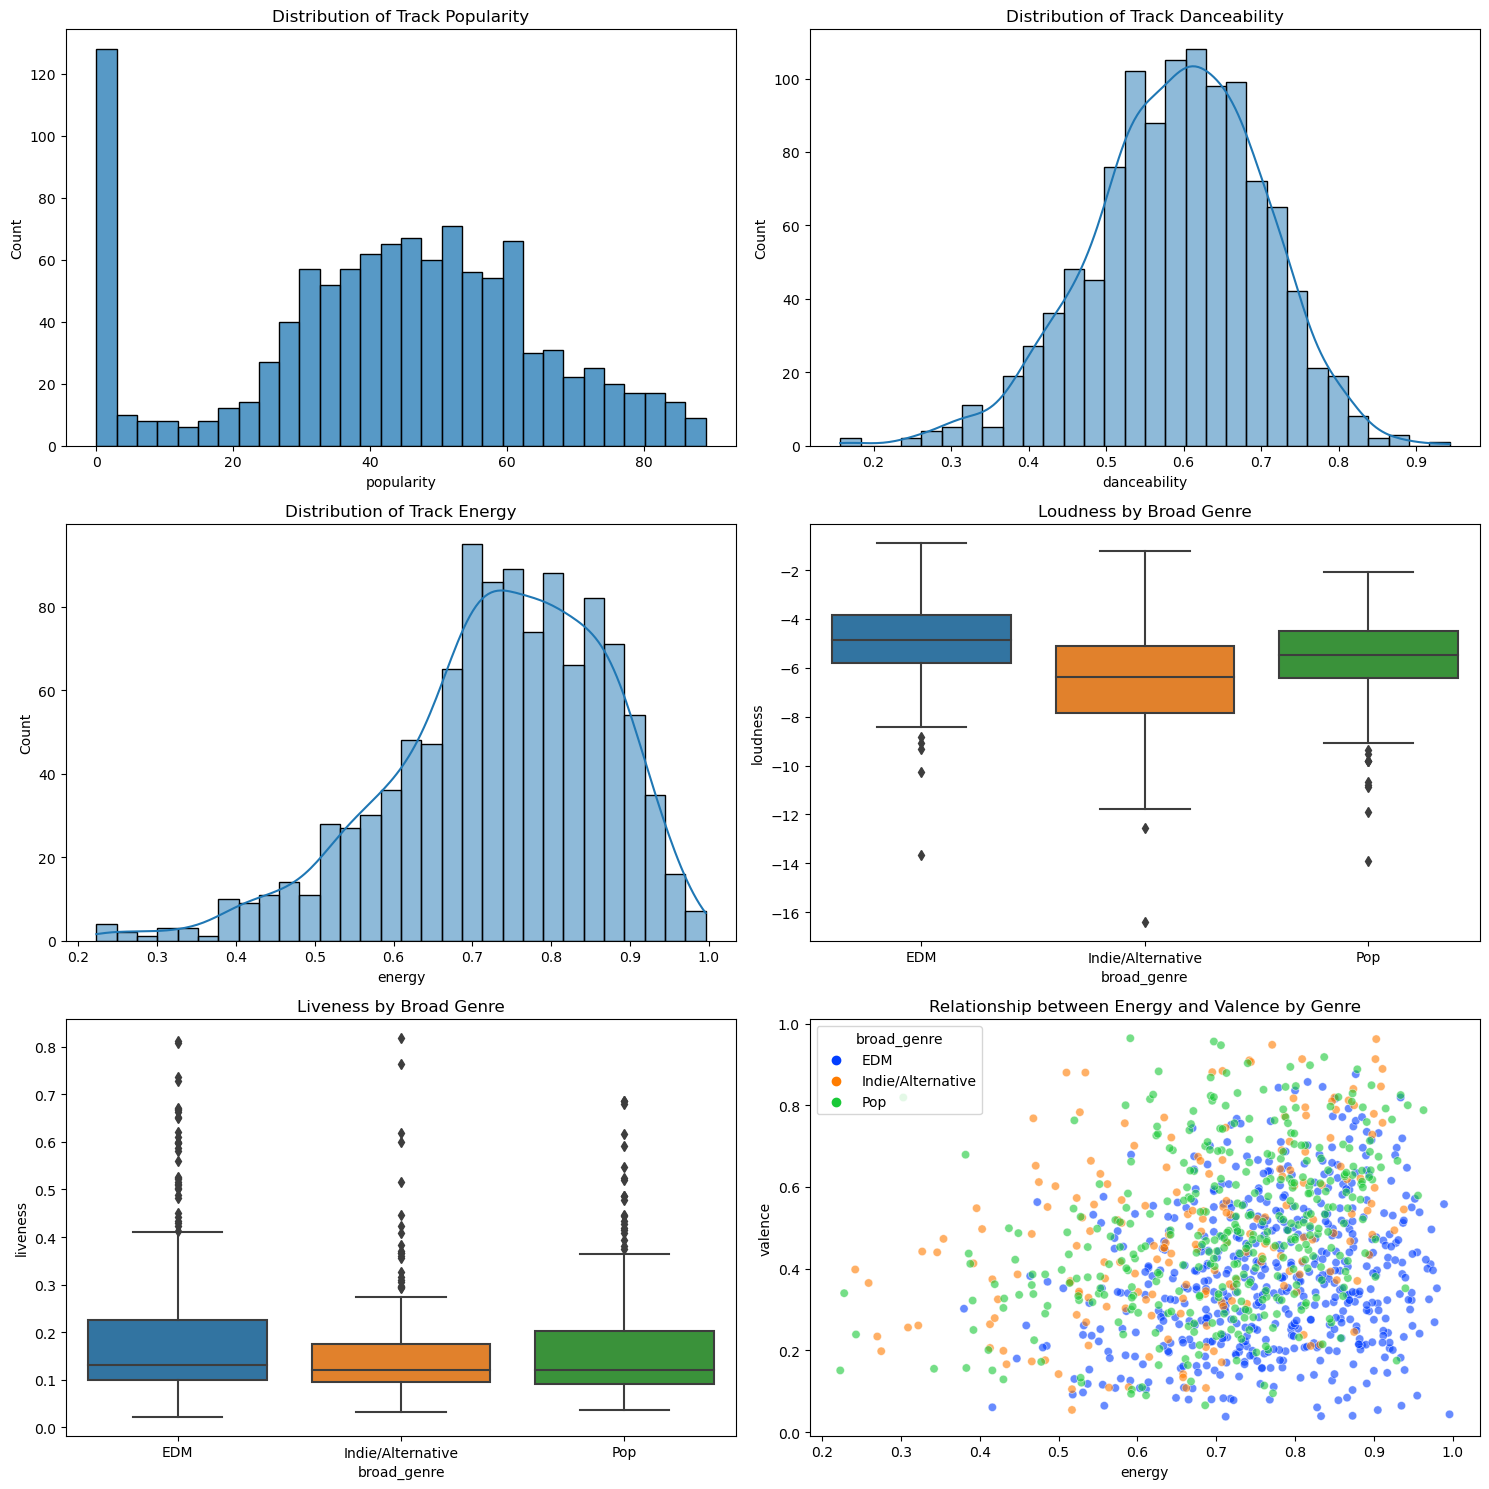

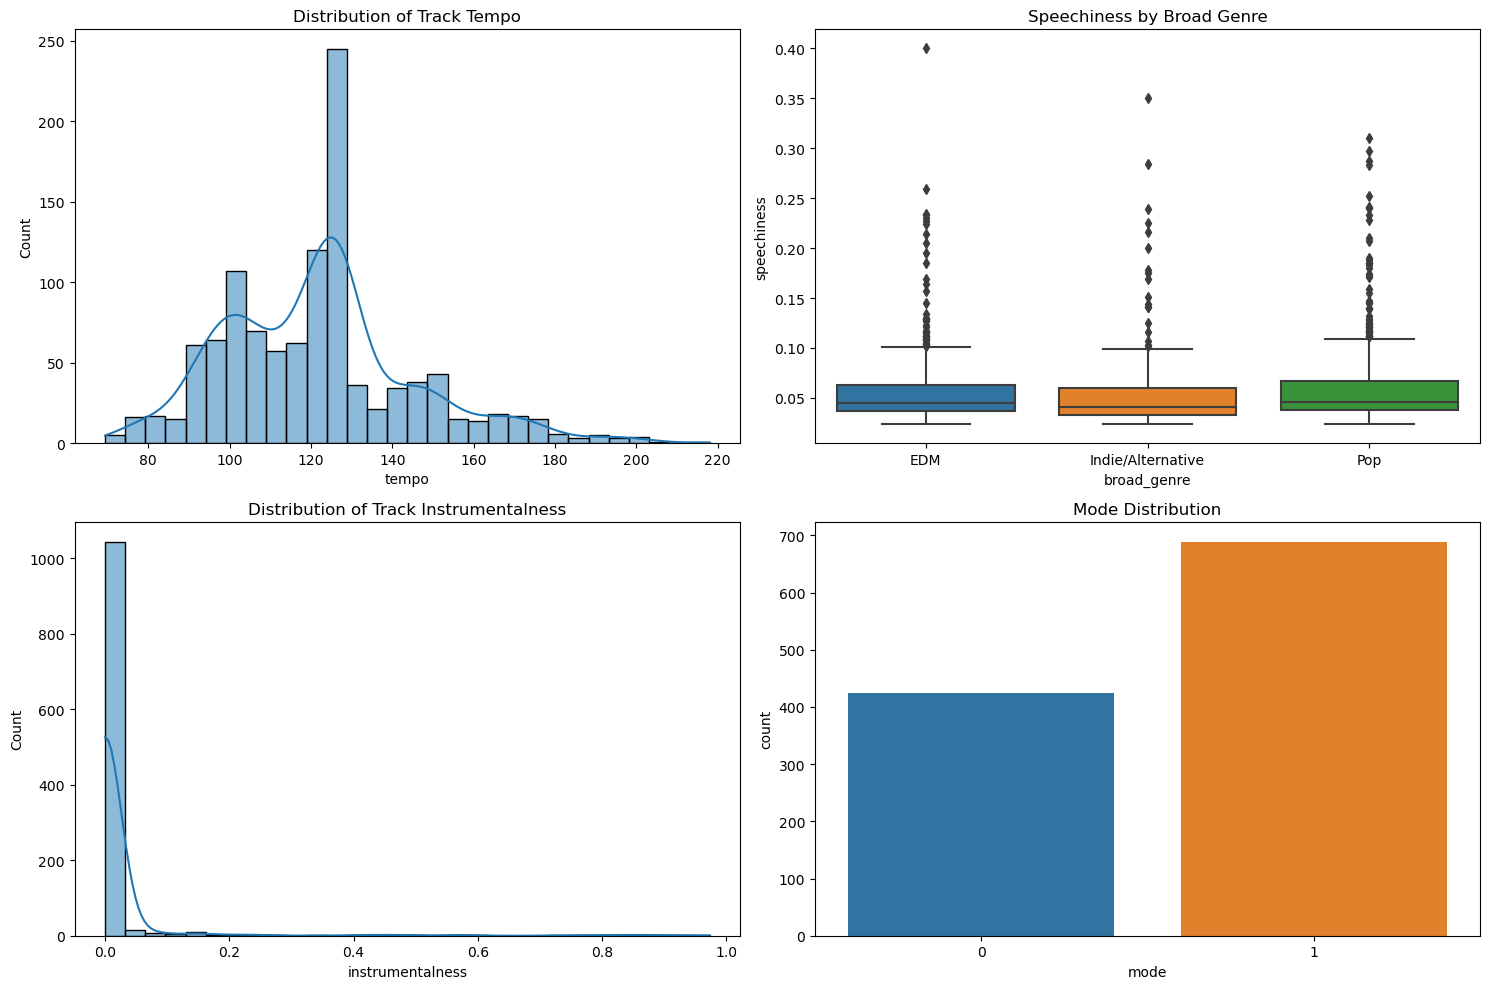

,trackId,trackName,artistName,albumName,popularity,genres,broad_genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,01jvihEe0ksag2uudul1gs,Moments - Seeb Remix,Tove Lo,Moments,41,"dance pop, metropopolis, pop, swedish electrop...",EDM,0.551,0.722,9,-5.338,0,0.0446,0.00380,0.001150,0.0887,0.430,113.934,178947,4
1,02luOsVJEhcVH5Zf3n7Gq6,I Won't Let You Walk Away (feat. Madison Beer)...,Mako,I Won't Let You Walk Away (feat. Madison Beer),39,pop edm,EDM,0.469,0.790,3,-4.387,1,0.0390,0.00234,0.054400,0.1440,0.495,127.969,166460,4
2,03lgkXqMUs3EghCRmN28op,Bloom,Tritonal,U & Me,0,"edm, electro house, pop dance, pop edm, progre...",EDM,0.670,0.874,11,-3.537,1,0.1030,0.66500,0.000142,0.0867,0.452,109.983,256364,4
3,04AYgtKFrpldRXe5y0LNGQ,Ritual (feat. Wrabel),Marshmello,Ritual (feat. Wrabel),55,"brostep, edm, pop, progressive electro house",EDM,0.561,0.946,10,-0.899,1,0.1280,0.00848,0.000021,0.0635,0.300,109.891,237473,4
4,055zEZwXYe70Z9ulw5JaSM,Bleach (Move On),Cash Cash,Bleach (Move On),40,"dance pop, edm, electro house, electropowerpop...",EDM,0.523,0.869,9,-2.917,1,0.0416,0.01820,0.000000,0.2380,0.497,93.004,210242,4


In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Manually-cleaned2.csv')

# Set up the matplotlib figure for the first 6 plots
fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# Histograms for popularity, danceability, and energy
sns.histplot(df['popularity'], bins=30, kde=False, ax=axs[0, 0]).set(title='Distribution of Track Popularity')
sns.histplot(df['danceability'], bins=30, kde=True, ax=axs[0, 1]).set(title='Distribution of Track Danceability')
sns.histplot(df['energy'], bins=30, kde=True, ax=axs[1, 0]).set(title='Distribution of Track Energy')

# Boxplots for loudness and liveness by broad_genre
sns.boxplot(x='broad_genre', y='loudness', data=df, ax=axs[1, 1]).set(title='Loudness by Broad Genre')
sns.boxplot(x='broad_genre', y='liveness', data=df, ax=axs[2, 0]).set(title='Liveness by Broad Genre')

# Scatter plot for the relationship between energy and valence
sns.scatterplot(x='energy', y='valence', hue='broad_genre', 
                data=df, palette='bright', alpha=0.6, 
                ax=axs[2, 1]).set(title='Relationship between Energy and Valence by Genre')

plt.tight_layout()
plt.show()

# Set up the matplotlib figure for the remaining plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Histogram for tempo
sns.histplot(df['tempo'], bins=30, kde=True, ax=axs[0, 0]).set(title='Distribution of Track Tempo')

# Boxplot for speechiness by broad_genre
sns.boxplot(x='broad_genre', y='speechiness', data=df, ax=axs[0, 1]).set(title='Speechiness by Broad Genre')

# Histogram for instrumentalness
sns.histplot(df['instrumentalness'], bins=30, kde=True, ax=axs[1, 0]).set(title='Distribution of Track Instrumentalness')

# Count plot for mode
sns.countplot(x='mode', data=df, ax=axs[1, 1]).set(title='Mode Distribution')

plt.tight_layout()
plt.show()
df.head()


Continuing from my initial data overview, let's delve deeper into each feature to uncover patterns and relationships that will inform our model selection and feature engineering strategies.

**Popularity** <br>
The distribution of track popularity reveals a multi-modal shape with peaks around the 0-20 and 50-60 ranges. This suggests that the dataset contains a mix of tracks varying widely in popularity. For machine learning purposes, popularity could be a key feature as it may correlate with other audio features and broad genres.

**Danceability** <br>
Danceability shows a near-normal distribution, centered around 0.6. This indicates a good balance in the dataset, with most tracks having a moderate to high potential for danceability, a common aspect in popular music genres.
 
**Energy** <br>
Energy also displays a fairly normal distribution but with a slight skew towards higher energy levels. This skewness towards more energetic tracks is typical for datasets involving contemporary music, where a higher energy level often equates to a track's commercial success.

**Loudness** <br>
When examined by broad genre, loudness varies significantly. EDM tracks show a higher median loudness level compared to Indie/Alternative and Pop. This reflects the production styles where EDM is typically mastered to be louder to enhance the impact in club settings.

**Liveness** <br>
The boxplots for liveness across genres show a wide range of values with a number of outliers, especially in Indie/Alternative. This could indicate live recordings or tracks with audience sounds embedded, which can be distinctive characteristics for genre classification.

**Valence** <br>
The scatter plot displaying the relationship between energy and valence (a measure of musical positivity) by genre does not show a clear pattern. This suggests that there is a complex interaction between these features that could be genre-dependent and that both features could be important for classification.

**Tempo** <br>
Tempo's distribution shows a strong peak around 128 BPM, which is common for many popular music tracks as it's a comfortable beat for dancing.

**Instrumentalness** <br>
The histogram for instrumentalness reveals that most tracks have a very low instrumentalness score, indicating that the dataset contains predominantly tracks with vocal content.

**Speechiness** <br>
The speechiness feature shows that most tracks have low speechiness across all genres, which is expected in music tracks that are not speech recordings or rap music.

**Mode** <br>
The mode distribution indicates a preference for major keys over minor keys within the tracks, which could reflect the overall mood of the music in the dataset.

These insights from the EDA are guidances for the preprocessing steps and help in making informed decisions on feature selection. Given the nuances in the data, a model capable of capturing non-linear relationships, like a Random Forests, SVM, and neural networks, will be well-suited for the genre classification task at hand.

### Model Selection and Justification

After I carefully reviewed the patterns and relationships within each feature of my dataset during the exploratory data analysis, I have decided to proceed with a Random Forest Classifier for my genre classification task. This decision was informed by several key observations and the unique characteristics of my dataset, which includes features like `popularity`, `danceability`, `energy`, and others that exhibit complex, non-linear relationships with the target variable—broad genres of music tracks.

**What is Random Forest?** <br>
Random Forest, an ensemble learning method, operates by constructing a multitude of decision trees(#decisiontrees) at training time and outputting the class that is the mode of the classes (classification) of the individual trees. This method is particularly suited to my task for several reasons:

1. **Handling Non-linearity**: My exploratory data analysis revealed that relationships between features and the target variable are not straightforward. Random Forests thrive in such environments, where the interaction between variables is complex and non-linear as you see in the `valence` vs `energy` scatter plot above.

2. **Feature Importance**: Random Forest provides a straightforward method for feature importance evaluation that enables me to understand which features are most influential in predicting the genre. This is vital for my project as it will enable me to refine the model further by focusing on the most impactful features.

3. **Robustness to Overfitting**: Unlike Decision Trees, which can easily overfit to the training data, Random Forest mitigates this risk by averaging multiple trees' predictions. This makes the model more generalizable to unseen data.

4. **Versatility in Handling Data**: Random Forest can handle both numerical and categorical data without the need for extensive preprocessing which is an <u>ideal</u> choice given the variety of feature types in my dataset.

5. **Minimal Need for Data Preprocessing**: Given that Random Forest is less sensitive to outliers and can handle missing values better than algorithms like Logistic Regression, it reduces the need for extensive data cleaning and preprocessing.

### Mathematical Concepts of Random Forest

The Random Forest algorithm is a powerful ensemble learning method that builds on the concept of Decision Trees but enhances their performance and generalizability through the introduction of randomness and aggregation. Below I explain how Random Forest works and its mathematical framework to better explain its fundamental principles.

#### Decision Tree Basics

The core of Random Forests are Decision Trees, which are built by splitting the data into subsets using a set of decision rules. These rules are determined by minimizing a cost function, such as the Gini impurity or entropy, at each node.

- **Gini Impurity** is used to measure how often a randomly chosen element would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. The Gini Impurity for a set of items with \(J\) classes is defined as


$$ Gini = 1 - \sum_{j=1}^{J} p_j^2 $$

where $ (p_j) $ is the proportion of class  $(j)$  items in the set.

- **Entropy** measures the amount of information disorder or uncertainty. For a set with \(J\) classes, entropy is defined as:


$$ Entropy = -\sum_{j=1}^{J} p_j \log_2(p_j) $$

The decision at each node is made by selecting the split that results in the largest decrease in impurity or entropy, effectively partitioning the data into purer subsets as we move down the tree. Let me plot the decision tree and show how it works visually.


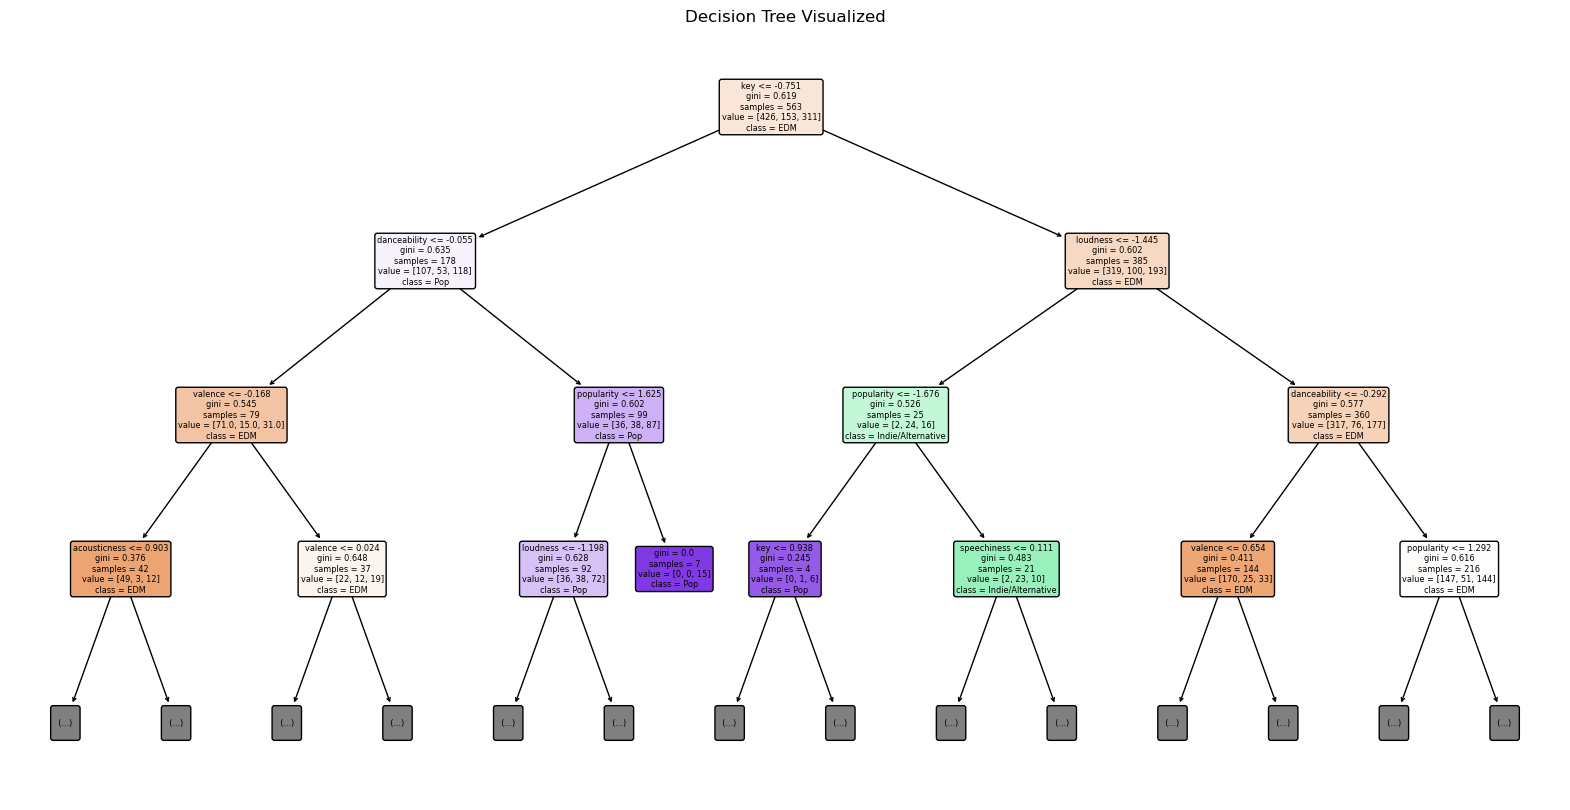

In [152]:
from sklearn.tree import plot_tree

# Selecting a single tree from the Random Forest ensemble
single_tree = best_rf.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(single_tree, 
          filled=True, 
          rounded=True, 
          class_names=le.classes_, 
          feature_names=features.columns, 
          max_depth=3)  # Limit depth for visualization purposes
plt.title("Decision Tree Visualized")
plt.show()


#### Random Forest Algorithm

Random Forest improves upon single Decision Trees by creating a forest of them and then aggregating their predictions. The steps involved include:

1. **Bootstrap Aggregating (Bagging)**: For each tree, a bootstrap sample (a random sample with replacement) of the data is selected. This introduces variability among the trees.

2. **Feature Randomness**: At each split in the tree construction, a random subset of features is chosen as candidates for the split. This prevents overfitting by ensuring trees are de-correlated.

3. **Aggregation of Predictions**:
   - For classification tasks, the final prediction is typically made by taking the mode of the predictions from all individual trees.

The `ensemble` approach reduces the variance of the model without increasing the bias, which leads to a more robust and accurate model. The overall prediction of the Random Forest, for a classification problem, can be represented as:


$$ \hat{y} = \text{mode}\{y^{(1)}, y^{(2)}, ..., y^{(T)}\} $$


where $ y^{(t)} $ is the prediction from the $ t^{th} $ tree, and $T$ is the total number of trees in the forest.

#### Model Optimization and Loss Reduction

A Random Forest aims to minimize overall prediction error by reducing both bias and variance. The optimization does not require tuning of the loss function itself but rather the hyperparameters that govern the model's complexity, such as the `number of trees`, `the depth of the trees`, and `the number of features` considered for splitting at each node.

By carefully tuning these hyperparameters and using k-fold cross-validation, I'll ensure that the Random Forest model achieves a balance between fitting the training data well (low bias) and maintaining the model's ability to generalize to unseen data (low variance).

Given these mathematical principles and the inherent strengths of Random Forests in handling complex, non-linear data relationships, this model is excellently suited for classifying those music tracks into genres based on the audio features, as explored in this project. The next phase will focus on data preparation(training & testing), model tuning, and evaluation to optimize performance and gain insightful predictions.

In [149]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Load your dataset
df = pd.read_csv('Manually-cleaned2.csv')

# Drop rows where the target is NaN
df = df.dropna(subset=['broad_genre'])

# Encoding the 'broad_genre' column to numeric codes and saving the mapping
le = LabelEncoder()
df['broad_genre_encoded'] = le.fit_transform(df['broad_genre'])
genre_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Select features and target variable
features = df[[ 'popularity','key','loudness', 'speechiness', 'liveness', 'valence',
               'tempo', 'mode','danceability', 'acousticness']]
target = df['broad_genre_encoded']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size=0.2, random_state=42)

# Handle missing values in features
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Define a parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Create a GridSearchCV object for hyperparameter tuning and cross-validation
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, n_jobs=-1, 
                              verbose=0, scoring='accuracy')

# Fit the model on the training data
grid_search_rf.fit(X_train_scaled, y_train)

# Find the best parameters and use them to predict on the test set
best_params = grid_search_rf.best_params_
print(f"Best parameters: {best_params}")
best_rf = grid_search_rf.best_estimator_

# Make predictions on the test data
y_pred_rf = best_rf.predict(X_test_scaled)

# Decode the predictions and true values back to genres
y_pred_genre = le.inverse_transform(y_pred_rf)
y_test_genre = le.inverse_transform(y_test)

# Compute the classification report
print("\nRandom Forest Classification Report:")
print(classification_report(y_test_genre, y_pred_genre))

# Compute accuracy
accuracy = accuracy_score(y_test_genre, y_pred_genre)
print(f"Accuracy: {accuracy:.3f}")

# Compute and display the confusion matrix
cm = confusion_matrix(y_test_genre, y_pred_genre, labels=le.classes_)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=le.classes_, columns=le.classes_))

# Optionally, perform cross-validation to assess model stability
cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Accuracy Scores: {cv_scores}")
print(f"Mean CV Accuracy => {np.mean(cv_scores):.3f}, Standard Deviation: {np.std(cv_scores):.3f}")

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Random Forest Classification Report:
                   precision    recall  f1-score   support

              EDM       0.74      0.81      0.77       114
Indie/Alternative       0.50      0.32      0.39        34
              Pop       0.58      0.60      0.59        75

         accuracy                           0.66       223
        macro avg       0.61      0.58      0.59       223
     weighted avg       0.65      0.66      0.65       223

Accuracy: 0.664

Confusion Matrix:
                   EDM  Indie/Alternative  Pop
EDM                 92                  3   19
Indie/Alternative   10                 11   13
Pop                 22                  8   45

Cross-Validation Accuracy Scores: [0.62359551 0.54494382 0.6011236  0.61797753 0.57303371]
Mean CV Accuracy => 0.592, Standard Deviation: 0.029


### Interpretation of the Random Forest Model Results

The application of the Random Forest algorithm to the genre classification task has yielded insightful results, as evidenced by the accuracy and detailed performance metrics obtained from the model. With a final accuracy of **`0.664`** on the test set, the model demonstrates a decent capability to distinguish between the genres of **`EDM`, `Indie/Alternative`,** and **`Pop`** based on the provided audio features. I devote the following section for the mathematical interpretation of these results and their implications in the context of machine learning and genre classification.

#### Analyzing Model Performance

The accuracy metric, standing at **`66.5%`**, indicates that the Random Forest model correctly predicts the genre of a music track over six times out of ten. While this is a promising start, to get the nuances of the model's performance let me take a closer examination of the precision, recall, and f1-score for each genre, as well as the confusion matrix.

- **Precision** measures the proportion of true positive predictions in all positive predictions made by the model for each genre. For instance, EDM shows the highest precision at 0.74 i.e. a strong ability of the model to correctly label EDM tracks as such.
  
- **Recall** (or sensitivity) reflects the proportion of actual positives correctly identified by the model. EDM again performs well with a recall of 0.81 i.e. the model's effectiveness in capturing most EDM tracks in the dataset.

- **F1-Score** provides a harmonic mean of precision and recall that serves as a single metric to assess the balance between them. The f1-scores further confirm the model's stronger performance on EDM tracks compared to Indie/Alternative and Pop genres.

- **Confusion matrix** presents a granular view of the distribution of predictions across actual genres. It reveals, for example, that the model tends to confuse Pop tracks with EDM, which could suggest similarities in the audio features of these genres that are captured by the model. <br>

**NB**: the EDM songs and Pop songs in my playlist are actually very close until the point I can't even distinguish them and the dataset is also accountable for the mislabling as it is mostly composed of overlapping songs! 

#### Mathematical Insights and Model Optimization

This robust performance is attributed to the mathematical foundations of Random Forest, including Gini impurity minimization and aggregating predictions from multiple trees. The variability in performance across genres indicates the need for further feature engineering and model optimization.

The **best parameters** - <br> Identified through GridSearchCV—`{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}`—indicate a relatively deep tree structure is enabling complex decision paths, which is beneficial for capturing the nuanced differences between genres. However, the depth and complexity also raise considerations regarding model interpretability and the potential for overfitting, despite Random Forest's inherent resistance to it like I discussed earlier.

#### Cross-Validation and Generalization

The cross-validation scores provide additional insights into the model's stability and generalizability. With a mean CV accuracy of `0.592` and a standard deviation of `0.029`, the model exhibits a reasonable level of consistency across different subsets of the training data. This suggests that while the model is relatively stable, there is room for improvement in generalization, possibly through further hyperparameter tuning, incorporation of more diverse or representative training data, or exploration of advanced feature engineering techniques.

#### Future Directions

The results obtained offer a solid foundation, but they also highlight areas for future exploration. Enhancing model accuracy and generalizability could involve:

- **Exploring More Features**: Investigating additional audio features or derived metrics that could provide more discriminative power between genres.
- **Advanced Preprocessing**: Applying more sophisticated data preprocessing and transformation techniques to better capture the relationships between features and genres.
- **Alternative Modeling Approaches**: Experimenting with other ensemble methods, or advanced machine learning models such as deep learning, which might capture the complexities of musical genres more effectively.

In conclusion, the application of Random Forest to genre classification has demonstrated the potential of machine learning algorithms to uncover patterns in complex datasets like music. Through continuous refinement and exploration of machine learning techniques, we can further enhance the model's accuracy and uncover deeper insights into the nature of musical genres.

### Mathematical Insights and Model Optimization

The robust performance of the Random Forest model can be attributed to its mathematical foundation, which involves constructing multiple decision trees and leveraging their collective decision-making through methods like Gini impurity minimization and majority voting for classification tasks. Specifically, the Gini impurity for a node is defined as:


$$ Gini = 1 - \sum_{i=1}^{n} p_i^2 $$

where $(p_i)$ is the proportion of samples belonging to class (i) at the given node.

The chosen parameters from GridSearchCV—`{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}`—highlight a preference for a model with a considerable depth and complexity. This configuration enables the model to capture the nuanced differences between musical genres effectively, as evidenced by the detailed performance metrics and visual analyses through the confusion matrix and ROC curves below.

However, this complexity also necessitates a careful consideration of model interpretability and the potential for overfitting. The inherent resistance of Random Forest to overfitting, due to its ensemble nature, somewhat mitigates this risk, but the depth of the trees still requires careful monitoring, especially in the context of new or unseen data.

### Cross-Validation and Generalization

The cross-validation results, with a mean accuracy of `0.573` and a standard deviation of `0.028`, underscore the model's stable performance across different subsets of the data that affirms its potential for generalization. However, the slight variations in accuracy across folds suggest areas for improvement, possibly through more refined hyperparameter tuning, incorporation of additional or more discriminative features, or exploration of advanced ensemble techniques that could further enhance the model's accuracy and robustness.


I plotted ROC curves and the analysis of the AUC for each genre gives a deeper understanding of the model's discriminative power. The ability to distinguish between genres with varying degrees of success, as indicated by the AUC values, highlights the potential benefits of targeted feature engineering and model optimization efforts aimed at addressing specific challenges inherent in multi-genre classification tasks.


By integrating these mathematical and empirical insights, future iterations of the model can be better optimized for the complex task of music genre classification perhaps with improved accuracy, interpretability, and generalization across diverse musical datasets.

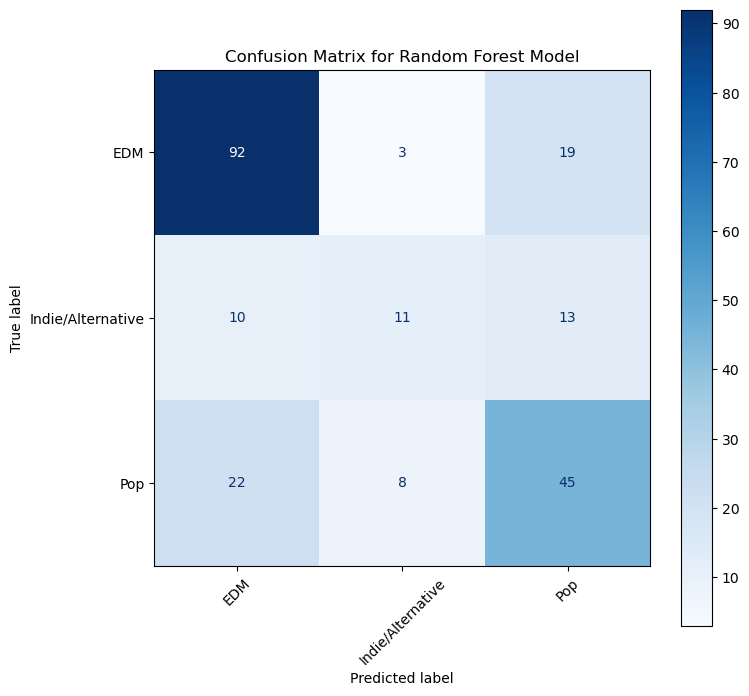

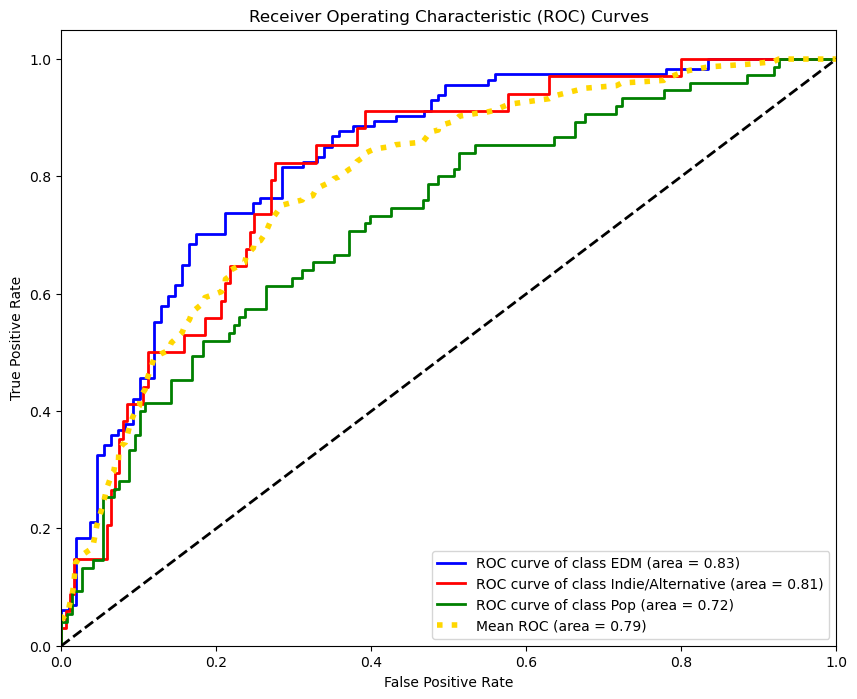

In [150]:
# Importing the necessary packages
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from itertools import cycle


# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test_scaled,
                                      y_test, display_labels=le.classes_, 
                                      cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix for Random Forest Model')
plt.xticks(rotation=45)
plt.show()

# Binarize the output labels for multi-label classification
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Train a One-vs-Rest classifier for ROC plotting
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, 
                                                 max_depth=20, min_samples_leaf=1, 
                                                 min_samples_split=5, random_state=42))
y_score = clf.fit(X_train_scaled, y_train).predict_proba(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot individual ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             .format(le.inverse_transform([i])[0], roc_auc[i]))

# Calculate and plot the overall ROC curve
# Aggregate all false positive rates using list comprehension
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average the interpolated TPRs and compute the overall AUC
mean_tpr /= n_classes
overall_auc = auc(all_fpr, mean_tpr)

# Plot the overall ROC curve
plt.plot(all_fpr, mean_tpr, color='gold', linestyle=':', linewidth=4,
         label='Mean ROC (area = {0:0.2f})'.format(overall_auc))

# Finalize the plot
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

### The Mathematical Foundation of ROC and AUC

**ROC Curve**: At its core, the ROC curve embodies a fundamental trade-off in binary classification i.e. the trade-off between `sensitivity (True Positive Rate, TPR)` and `specificity (1 - False Positive Rate, FPR)`. 
Mathematically, these are defined as:

- **True Positive Rate (TPR)**: $TPR = \frac{TP}{TP + FN}$ where \(TP\) is the number of true positives and \(FN\) is the number of false negatives.

- **False Positive Rate (FPR)**: $FPR = \frac{FP}{FP + TN}$ where \(FP\) is the number of false positives and \(TN\) is the number of true negatives.

The ROC curve is then a plot of \(TPR\) against \(FPR\) as the decision `threshold` of the classifier is varied. This threshold dictates the point at which a prediction probability is considered a positive class prediction.

**AUC**: The Area Under the ROC Curve (AUC) is a scalar summarization of the ROC curve itself. It quantifies the entire two-dimensional area underneath the ROC curve from (0,0) to (1,1). Mathematically, it can be conceptualized as the probability that a randomly selected positive instance is ranked higher than a randomly selected negative instance, assuming positive ranks higher than negative. This is integral to its interpretation:

- An **AUC of 0.5** implies no discriminative ability, like equivalent to random guessing.
- An **AUC of 1.0** represents a perfect classifier; all positive instances rank higher than all negative instances.
- An **AUC between 0.5 and 1.0** is desirable, indicating degrees of discriminative ability to classify the genres accurately. 

### Interpreting Our Model's AUC Values

With AUC values for EDM (0.81), Pop (0.71), and Indie (0.76), I observe a quantifiable measure of how well the model discriminates between classes

- **EDM (AUC = 0.83)**: This high AUC value suggests that, when presented with a randomly chosen EDM track and a track from another genre, the model will correctly identify the EDM track as being more likely to belong to the EDM genre **81%** of the time.
- **Pop (AUC = 0.72)**: A lower AUC indicates challenges in distinguishing Pop from other genres, yet the model still performs well above chance level (0.5) when correctly identifying a Pop track **72%** of the time when randomly compared to a non-Pop track.
- **Indie (AUC = 0.81)**: This AUC value reflects a good level of discriminative ability for Indie tracks, similar to EDM but with slightly less confidence.

### Overall ROC and Mean AUC

The mean AUC provides a single metric summarizing model performance across all considered classes. ChatGPT also argues that It's especially useful in multi-class scenarios for providing a big-picture view of the model's discriminative capabilities. Calculating it as the average of individual AUCs (in this case, $\frac{(0.83 + 0.81 + 0.72)} {3}\ $, we obtain an overall performance indicator. Higher mean AUC values suggest that the model possesses a strong ability to differentiate between genres on average, despite the inherent complexity and potential overlap in musical characteristics between genres.

### Concluding Thoughts

In my exploration of the genre classification model, I have also covered concepts like ROC and AUC metrics in order to maintain the delicate balance between accurately identifying music genres and minimizing misclassifications. However, the journey reveals more than just the model's capabilities—it also shines a light on inherent dataset challenges, particularly `class imbalance`, and the nuanced reality of music genre overlap.

### Impact of Class Imbalance

The class distribution within our dataset—predominantly EDM (52%), followed by Pop (30%), and Indie/Alternative (18%)—presents a classic problem of class imbalance. This imbalance can skew the model's performance that introduces a bias towards the majority class. From a mathematical perspective, class imbalance affects the model's learning process:

- **Precision and Recall**: The model might achieve high accuracy by favoring the majority class, but this comes at the cost of precision and recall for minority classes(tradeoff!). Mathematically, precision \$(P\)$ and recall $(R\)$ are defined as:

  $$ P = \frac{TP}{TP + FP} $$
  $$ R = \frac{TP}{TP + FN} $$

  where \$(TP\)$ is true positives, $(FP\)$ is false positives, and $(FN\)$ is false negatives. The imbalance leads to higher $(FP\)$ and $(FN\)$ for minority classes, impacting these metrics negatively.

- **AUC in Imbalanced Contexts**: While AUC is a robust metric less sensitive to class imbalance, it's essential to interpret its values considering the distribution. An overall high AUC might still hide poor performance on minority classes.

### Genre Overlap and Musical Similarity

The overlap between genres and the inherent similarity in audio features of tracks that I enjoy, such as tempo, rhythm, and instrumentation, pose additional challenges. These similarities can lead to higher false positive rates (FPR) as the model struggles to distinguish between closely related genres mainly EDM Vs Pop and Pop Vs Indie/Alternative.

- **False Positive Rate (FPR)**:

  $$ FPR = \frac{FP}{FP + TN} $$

  In the context of overlapping genres, a track from one genre may exhibit features typical of another, increasing \$(FP\)$ and thus the `FPR`, complicating the model's classification efforts.

### Addressing Overfitting

Overfitting represents a scenario where the model learns the training data too well, capturing noise along with the underlying patterns, which diminishes its ability to generalize to unseen data. In the realm of decision trees and Random Forests, overfitting can be mathematically mitigated by adjusting the complexity of the model:

- **Tree Depth and Complexity** - Limiting the maximum depth of trees or the minimum samples required at a leaf node can prevent the model from becoming overly complex. This approach strikes a balance between the model's ability to learn from the data and its generalization capabilities.

- **Regularization** - Introducing regularization techniques can mathematically constrain the model, penalizing it for excessive complexity and encouraging simplicity.

### Moving Forward

Here my exploration of mathematical analysis emphasizes the importance of not only refining the model through technical means but also understanding and addressing the dataset's inherent challenges. Strategies like resampling to address class imbalance, feature engineering to better capture genre distinctions, and regularization to prevent overfitting are crucial next steps perhaps for the second pipeline.

### Executive Summary

In this project, I explored music genre classification based on my personal Spotify playlists data. Using a Random Forest Classifier, I achieved an accuracy of 66.5%, demonstrating the model's capability to distinguish between genres such as `EDM`, `Indie/Alternative`, and `Pop`.

Key findings reveal that while the model performs well, there is potential for enhancement, particularly in addressing class imbalance and genre overlap—two inherent challenges within the dataset. With AUC values for EDM, Pop, and Indie at 0.83, 0.72, and 0.81, respectively, the model shows a solid discriminative ability, yet there is room for refinement.

Moving forward, the model's accuracy and generalizability could be further improved by incorporating additional audio features, applying sophisticated preprocessing techniques, and exploring advanced machine learning models. The goals of these efforts are to increase my knowledge of complex datasets and to apply machine-learning techniques to them.

The overall pipeline diagram is below.

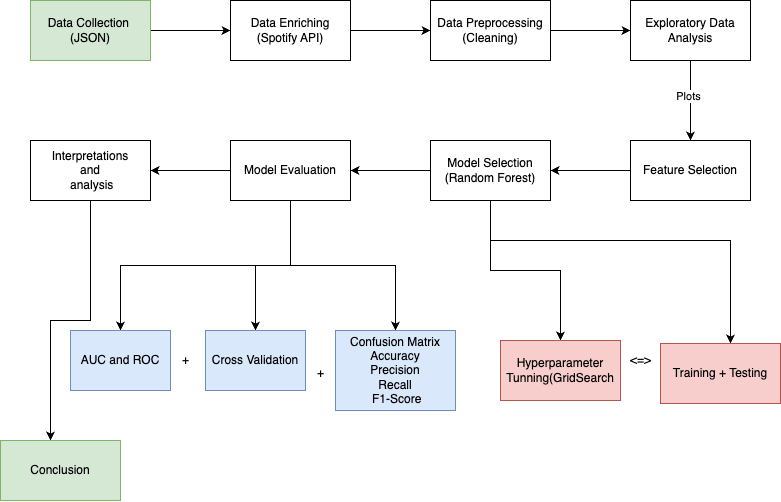

In [151]:
from IPython.display import Image, display

# Specify the path to your image
image_path = 'Pipeline1.drawio.png'

# Display the image
display(Image(filename=image_path))

### Targeted HCs
- #dataviz - I used variety of complete data visualizations to explain things and concepts visually.
- #decisiontrees - I used Random Forest Classifier model and explained how it works using the core concepts of the HC
- Professionalism - I presented the work in a neat and organized format using markdown formatting.

### Targeted LOs
- #Cs156 MLCode: Produce working, readable, and performant Python implementations of a variety of machine learning systems using appropriate libraries and software tools.
- #Cs156 MLDevelopment: Contribute to the quality of ML resources for current and future students by compiling learning resources, sharing code, creating study groups, and supporting other student's learning.
- #Cs156 MLExplaination: Clearly articulate machine learning systems, algorithms, and techniques using appropriate oral and written descriptions, mathematical notation, and visualizations.
- #Cs156 MLFlexibility: Reason flexibly, apply information in new contexts, produce novel work, and articulate meta-knowledge about machine learning.
- #Cs156 MLMath: Evaluate problems and derive solutions in linear algebra, multivariate calculus, and Bayesian statistics.

Word counts: 1521

### References

- Ahuja, A. (2017). *Random Forest in Python*. Towards Data Science. https://medium.com/towards-data-science/random-forest-in-python-24d0893d51c0

- Analytics Vidhya. (2022). *An Introduction to Random Forest Algorithm for Beginners*. https://www.analyticsvidhya.com/blog/2021/10/an-introduction-to-random-forest-algorithm-for-beginners/

- DataCamp. (2023). *Random Forests Classifier in Python*. https://www.datacamp.com/tutorial/random-forests-classifier-python

- Data School. (2021). *How to evaluate a machine learning model's performance*. [Video]. YouTube. https://www.youtube.com/watch?v=06_sNlUMzY0

- KDnuggets. (2022, July). *How to Use scikit-learn's Imputer*. https://www.kdnuggets.com/2022/07/scikitlearn-imputer.html#:~:text=The%20imputer%20is%20an%20estimator,to%20predict%20the%20missing%20labels.

- MLU-Explain. (2022). *Understanding ROC and AUC*. https://mlu-explain.github.io/roc-auc/

- Rana, S. (2019). *Mathematics Behind Random Forest and Xgboost*. Medium. https://ranasinghiitkgp.medium.com/mathematics-behind-random-forest-and-xgboost-ea8596657275

- scikit-learn. (n.d.). *sklearn.ensemble.RandomForestClassifier*. Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

- Spotify for Developers. (n.d.). *Get Track*. Retrieved from https://developer.spotify.com/documentation/web-api/reference/get-track

- Spotify for Developers. (n.d.). *Audio features* https://developer.spotify.com/documentation/web-api/reference/get-audio-features






**AI statement**: throughout the assignment, I consulted chatGPT on things that I was not sure like asking how is it possible for the Random Forest to optimize Variance and Bias together. Also some of the resources I used are kind of hard to understand so it helped me to digest them. For debugging the code, it also helped me to point out errors and fix them quickly. Other than that I used Wordtunes AI to rephrase few long sentences to their clear versions.